# COVID-19 Case Prediction CNN and LSTM Neural Network Case Study Comparison


> Robert Martinez

> Aarush Mathur

> ECE884: Neural Networks and Deep Learning, Dr. Fathi Salem

> Benchmark Model by Yohan Chung



#Introduction
Case Study Comparison for different configurations of CNN and LSTM stacked networks. In this benchmark comparison a CNN/Stacked LSTM, Stacked CNN/Stacked LSTM and Stacked CNN/Stacked LSTM with increased pooling are tested and the results on run time and root mean square log error are tabulated in our paper.


The pandemic of Coronavirus (COVID-19) became reality and many countries around the globe strive to contain further spread of the virus with social distancing as well as qurantining of those who potentially contact the infected. At this moment, the project aims to predict future of the infected by geo location and identify which country needs more attention. The prediction of the newly infected starts with reading dataset which are provided by Johns Hopkins University, and the dataset includes the number of cases confirmed with Covid-19 as well as fatalities by country and state. I would like to thank for sharing the dataset so that data scientists can contribute to modelling data.

# 1. Feature Engineering

After reading dataset, there are two main actions that I make:

* Country and state fields are combined as called Geo_Code in order to easily filter and sort dataset by geo location.
* The scale of ConfirmedCases and Fatalities is normalised to the range from 0 to 1

The normalisation is typically performed in order to reduce computation time due to that the numbers become small. In addition, it is normalised that a model can learn potential patterns in data in the same scale. For example, 1% increase in the infected from countries with large and small population can be regarded as same impact on the model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import warnings
from sklearn.preprocessing import PowerTransformer
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1) 

class DataConstants(object):
           
    NORMALISE_SCALE = 1
    KEY_COLS = [ 'Country_Region', 'Province_State', 'Day', 'ConfirmedCases', 'ConfirmedCases_log', 'ConfirmedCases_Max', 'Fatalities', 'Fatalities_log', 'Fatalities_Max' ]
    HISTORICAL_STEPS = 7
    INPUT_FEAT_C = [ 'ConfirmedCases_log', 'ConfirmedCases_acc' ]  
    INPUT_FEAT_F = [ 'Fatalities_log' ]   
    TARGET_C = [ 'ConfirmedCases_log' ]
    TARGET_F = [ 'Fatalities_log' ]
    TEST_DAY_FROM = 71
    TEST_DAY_TO = 79
    

class Util(object):
    '''
        Helper class to contain util function
    '''
    class BackColors:
        MAGENTA = '\033[35m'
        CYAN    = '\033[36m'  
        ENDC = '\033[0m'
        UNDERLINE = '\033[4m'

    @staticmethod
    def display(title, mesg=''):
        print('\n{}{}{}\n{}'.format(Util.BackColors.CYAN, title, Util.BackColors.ENDC, mesg))
    
    @staticmethod
    def to_datetime(dt):
        return datetime.datetime.strptime(dt, '%Y-%m-%d')
    
    @staticmethod
    def to_isoweekday(dt):
        return datetime.datetime.strptime(dt, '%Y-%m-%d').isoweekday()
    
    @staticmethod
    def count_days(dt):
        return (dt - datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")).days


'''
Repository to read and retrieve dataframe from source 
'''
####Why doesn't this have all the locations
class DataFrameReader(object):
    
    country_states = [
        ('Australia', 'New South Wales'),
        ('Australia', 'Victoria'),
        ('Australia', 'Queensland'),
        ('Korea, South', 'Unknown'),
        ('US', 'New York'),
        ('Iran', 'Unknown'),
        ('Italy', 'Unknown'),
        ('China', 'Hubei'),
        ('Brazil', 'Unknown'),
        ('China', 'Beijing'),
        ('Lebanon', 'Unknown'),
        ('Russia', 'Unknown'),
        ('US', 'Kansas'),
        ('US', 'Florida'),
        ('US', 'Illinois'),
        ('US', 'Maryland'),
        ('US', 'Michigan'),
        ('US', 'Mineesota'),
        ('United Kingdom', 'Bermuda'),
        ('United Kingdom', 'Gibraltar'),
        ('United Kingdom', 'Montserrat'),
        ('United Kingdom', 'Unknown'),
        ('Malaysia', 'Unknown'),
        ('Mongolia', 'Unknown'),
        ('New Zealand', 'Unknown'),
    ]

    n_states = 0    
    power_transformer = None
    
    def __init__(self):
        
        self.power_transformer = PowerTransformer()
    
    def read(self):   
        
        # df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
        # df_test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')  
        df = pd.read_csv('train.csv')
        df_test = pd.read_csv('test.csv')
        print(df.columns)
        df, df_test = self._filter(df, df_test)
        df, df_test = self._preprocess(df, df_test)
        df, df_test = self._transform(df, df_test)
        
        return df, df_test
    
    def _filter(self, df, df_test):
        
        df = df[((df.Country_Region != 'France') & (df.Province_State != 'Saint Barthelemy')) & ((df.Country_Region != 'Guyana') & (df.Province_State != 'Unknown'))]
        
        return df, df_test
        
    def _preprocess(self, df, df_test):
        
        # Fill empty values
        df = df.fillna({'Province_State': 'Unknown'})
        df_test = df_test.fillna({'Province_State': 'Unknown'})
        
        # Replace special char in fields
        df['Country_Region']= df['Country_Region'].str.replace("'", "")
        df['Province_State']= df['Province_State'].str.replace("'", "")
        df_test['Country_Region']= df_test['Country_Region'].str.replace("'", "")
        df_test['Province_State']= df_test['Province_State'].str.replace("'", "")

        # Convert dates to day count (from the starting date)
        df['Date_dt'] = df['Date'].map(f.to_datetime)
        df_test['Date_dt'] = df_test['Date'].map(f.to_datetime)
        df['Day'] = df['Date_dt'].map(f.count_days)##Used built in to count days
        df_test['Day'] = df_test['Date_dt'].map(f.count_days)

        # Correct outliers
        df.loc[((df.Country_Region == 'Iceland') & (df.Province_State == 'Unknown') & (df.Day == 53)), 'Fatalities'] = 0
        df.loc[((df.Country_Region == 'Kazakhstan') & (df.Province_State == 'Unknown') & (df.Day == 58)), 'Fatalities'] = 0
        df.loc[df.index == 4874, 'ConfirmedCases'] = 146
        df.loc[df.index == 19733, 'Fatalities'] = 0
        df.loc[(df.index >= 17199) & (df.index <= 17202), 'Fatalities'] = 0  
        
        return df, df_test
   
    def _transform(self, df, df_test):     
        
        # Generate delta and log-transform
        df['ConfirmedCases_log'] = 0.0
        df['Fatalities_log'] = 0.0
        
        self.n_states = len(self.country_states)
        
        df = df[(df.Country_Region.isin([ g[0] for g in self.country_states ]) ) & (df.Province_State.isin([ g[1] for g in self.country_states ]))]
        df_test = df_test[(df_test.Country_Region.isin([ g[0] for g in self.country_states ]) ) & (df_test.Province_State.isin([ g[1] for g in self.country_states ]))]        
#         for c, s in df.groupby(['Country_Region', 'Province_State']): self.n_states += 1            
        f.display('Total Countries', self.n_states)

        from sklearn.preprocessing import LabelEncoder
        lbl_encoder = LabelEncoder()
        df['Geo_Code'] = df['Country_Region'].astype(str) + '_' + df['Province_State'].astype(str)
        df['Geo_One_Hot'] = None
    
        df['Geo_Code'] = lbl_encoder.fit_transform(df['Geo_Code'])
        
        def one_hot(x):
            n = np.empty(self.n_states)
            n.fill(0)
            n[x]=1
            return n
        df['Geo_One_Hot'] = df.Geo_Code.apply(one_hot)
       
#         for c, s in df[(df.Country_Region=='Australia')].groupby(['Country_Region', 'Province_State']):
            
#             df_a = df[(df.Country_Region==c[0]) & (df.Province_State==c[1])]
#             #print(c[0], c[1], df_a.Geo_Code.values[0], df_a.Geo_One_Hot.values[0])
#             one_hot = df_a.Geo_One_Hot.values[0]
#             [ print(i) for i in range(len(one_hot)) if one_hot[i] == 1 ]
                
        # Normalise regardless of Group        
        for c, s in df.groupby(['Country_Region', 'Province_State']):
            
            df_temp = df[(df.Country_Region == c[0]) & (df.Province_State == c[1])]
            
            df_case = df_temp.ConfirmedCases.rolling(3).sum()
            df_fat = df_temp.Fatalities.rolling(3).sum()
            
            # Convert to rolling sum
            idx = df_temp.head(1).index.values[0]
            for i in range(len(df_temp)):                
                df.at[idx + i, 'ConfirmedCases_acc'] = df_case[idx + i] if not math.isnan(df_case[idx + i]) else 0
                df.at[idx + i, 'Fatalities_acc'] = df_fat[idx + i] if not math.isnan(df_fat[idx + i]) else 0
                
        df['ConfirmedCases_log'] = np.log1p(df.ConfirmedCases)#self.power_transformer.fit_transform(df[['ConfirmedCases']]) #np.log1p(df.ConfirmedCases) #df.ConfirmedCases / df.ConfirmedCases.max() * DataConstants.NORMALISE_SCALE
        df['Fatalities_log'] = df.Fatalities / df.Fatalities.max() * DataConstants.NORMALISE_SCALE#np.log1p(df.Fatalities) #df.Fatalities / df.Fatalities.max() * DataConstants.NORMALISE_SCALE
        df['ConfirmedCases_Max'] = df.ConfirmedCases.max()
        df['Fatalities_Max'] = df.Fatalities.max()
        
        # continuous to discrete
#         df['ConfirmedCases_bin'] = pd.cut(df.ConfirmedCases_log, bins=20, labels=np.arange(20), right=False)        
        
#         # Normalise by Group
#         df[['ConfirmedCases_log']] = df.groupby(['Geo_Code'])[['ConfirmedCases']].transform(lambda x: (x / x.max() * DataConstants.NORMALISE_SCALE) if x.max() != 0 else 0)
#         df[['Fatalities_log']] = df.groupby(['Geo_Code'])[['Fatalities']].transform(lambda x: (x / x.max() * DataConstants.NORMALISE_SCALE) if x.max() != 0 else 0)
#         df = pd.merge(df, df.groupby(['Geo_Code'])[['ConfirmedCases', 'Fatalities']].max().reset_index()\
#                       .rename(columns={ 'ConfirmedCases': 'ConfirmedCases_Max',  'Fatalities': 'Fatalities_Max'}), on='Geo_Code', how='left')
        
        
        return df, df_test
    
const = DataConstants()
f = Util()  
dr = DataFrameReader()
df, df_test = dr.read()
f.display('Columns', df.columns.tolist())
f.display('Fill blank fields', df[ DataConstants.KEY_COLS ].isna().sum())
f.display('Confirm no inf')
df[(df.ConfirmedCases_log == np.inf)  | (df.Fatalities_log == np.inf)][ DataConstants.KEY_COLS ]


Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities'],
      dtype='object')

Total Countries
25

Columns
['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities', 'Date_dt', 'Day', 'ConfirmedCases_log', 'Fatalities_log', 'Geo_Code', 'Geo_One_Hot', 'ConfirmedCases_acc', 'Fatalities_acc', 'ConfirmedCases_Max', 'Fatalities_Max']

Fill blank fields
Country_Region        0
Province_State        0
Day                   0
ConfirmedCases        0
ConfirmedCases_log    0
ConfirmedCases_Max    0
Fatalities            0
Fatalities_log        0
Fatalities_Max        0
dtype: int64

Confirm no inf



,Country_Region,Province_State,Day,ConfirmedCases,ConfirmedCases_log,ConfirmedCases_Max,Fatalities,Fatalities_log,Fatalities_Max


# 2. Exploratory Data Analysis (EDA)

The list of geo location is selected to shape a shape of trend over time, and identify common patterns in a time series.

In [ ]:
df[(df.Country_Region == 'Australia') & (df.Province_State == 'New South Wales')]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Date_dt,Day,ConfirmedCases_log,Fatalities_log,Geo_Code,Geo_One_Hot,ConfirmedCases_acc,Fatalities_acc,ConfirmedCases_Max,Fatalities_Max
1035,1036,New South Wales,Australia,2020-01-22,0.0,0.0,2020-01-22,0,0.000000,0.000000,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,345813.0,33998.0
1036,1037,New South Wales,Australia,2020-01-23,0.0,0.0,2020-01-23,1,0.000000,0.000000,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,345813.0,33998.0
1037,1038,New South Wales,Australia,2020-01-24,0.0,0.0,2020-01-24,2,0.000000,0.000000,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,345813.0,33998.0
1038,1039,New South Wales,Australia,2020-01-25,0.0,0.0,2020-01-25,3,0.000000,0.000000,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,345813.0,33998.0
1039,1040,New South Wales,Australia,2020-01-26,3.0,0.0,2020-01-26,4,1.386294,0.000000,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3.0,0.0,345813.0,33998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1146,New South Wales,Australia,2020-05-11,3053.0,44.0,2020-05-11,110,8.024207,0.001294,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9159.0,132.0,345813.0,33998.0
1146,1147,New South Wales,Australia,2020-05-12,3059.0,45.0,2020-05-12,111,8.026170,0.001324,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9165.0,133.0,345813.0,33998.0
1147,1148,New South Wales,Australia,2020-05-13,3063.0,45.0,2020-05-13,112,8.027477,0.001324,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9175.0,134.0,345813.0,33998.0
1148,1149,New South Wales,Australia,2020-05-14,3071.0,45.0,2020-05-14,113,8.030084,0.001324,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9193.0,135.0,345813.0,33998.0


* y: normalised, x: day
* Not all start from the same day
* but has deviation in shape which can be stated as custom weights and bias in LSTM


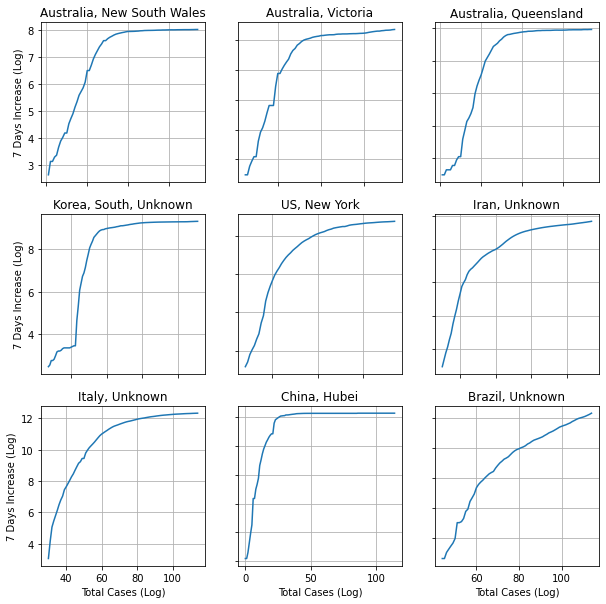

In [ ]:
df_arr = []

for g in dr.country_states:    
    df_arr.append(df[(df.Country_Region==g[0]) & (df.Province_State==g[1]) & (df.ConfirmedCases > 10)])   

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10,10))

for a in ax.flat:    a.set(xlabel='Total Cases (Log)', ylabel='7 Days Increase (Log)')
for a in ax.flat:    a.label_outer()
    
counter = 0
for row in ax:
    for col in row:
        if len(df_arr) > counter:
            plot_df = df_arr[counter]
            col.title.set_text('{}, {}'.format(plot_df.Country_Region.values[0], plot_df.Province_State.values[0]))
            col.grid()
            col.plot(plot_df.Day, plot_df.ConfirmedCases_log, label='xxx')
        counter += 1
plt.show()

One of the most remarkable patterns I can find was that a time series of Covid-19 is similar to common growth curve, for example new cases of AIDS in a country and child growth curve, in a sense that the observed data points grow expoentially and flatten out afterward. This growth curve looks a lot like ***Logistic / Sigmoid*** curve.

![New cases of AIDS in the United Stated over Years](http://www.nlreg.com/aids.jpg)

# 3. Prepare Model Input Data

In [ ]:
import time
import random
import tensorflow as tf
from tensorflow.keras import Model, Sequential, backend as K
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Reshape, Concatenate, Embedding, Flatten, TimeDistributed, RepeatVector, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, MaxPooling2D, ConvLSTM2D, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau


class TimeSeriesModelRepo(object):
    '''
        Repository to create an instance for LSTM model
    '''

    verbose = 0
    
    input_shape = None
    input_shape_geo = None

    def __init__(self):
        pass

    def make_sequential_input(self, input_df):
        
        # historical time steps in last 7 days at time t
        historical_steps = DataConstants.HISTORICAL_STEPS
        
        # ConfirmedCases and Fatalities columns
        features_c = DataConstants.INPUT_FEAT_C 
        features_f = DataConstants.INPUT_FEAT_F 
        
        tic = time.perf_counter()   
        inputs_c, inputs_ca, inputs_f, inputs_geo, inputs_hot, targets_c, targets_f = [], [], [], [], [], [], []

        # Iterate through each geo location
        for c, s in input_df.groupby(['Country_Region', 'Province_State']):
            country = c[0]
            state = c[1]

            print('Country: {}, State: {},'.format(country, state), end=' ')

            # Country df
            co_df = input_df.loc[(input_df.Country_Region==country) & (input_df.Province_State==state)]        
            co_start_idx = co_df.index.values[0]

            activate_tracking = False
            activated_i = 0

            for i in range(0, len(co_df)):
                idx = co_start_idx + i     
                last_idx = idx + historical_steps

                if co_df.tail(1).index[0] >= last_idx:

                    delta_df = co_df['ConfirmedCases'].diff()
                    delta_1 = delta_df.at[idx + 1]
                    delta_2 = delta_df.at[idx + 2]

                    # Start tracking when a data point starts moves up and down
                    if not activate_tracking \
                    and co_df.at[idx, 'ConfirmedCases'] >= 10 \
                    and (not math.isnan(delta_1) and delta_1 > 0) \
                    and (not math.isnan(delta_2) and delta_2 > 0):
                        
                        activate_tracking = True
                        activated_i = i + historical_steps
                        print('Train from Day: {}'.format(co_df.at[last_idx, 'Day']))

                    if activate_tracking == True and i >= activated_i:

                        data = co_df.loc[idx : last_idx]
                        steps = data.iloc[-(historical_steps + 1):-1]
                        last = data.tail(1)  
                        
                        for i in range(1):
                            # inputs for geo location, confirmed case sequence, and fatality sequence (from time t - 7 to t - 1)
                            inputs_geo.append(np.array(last[['Geo_Code']]).reshape(-1).tolist())  
                            inputs_hot.append(np.array(last[['Geo_One_Hot']]).reshape(-1).tolist())  
                            inputs_c.append(np.array(steps[['ConfirmedCases_log']]).tolist()) 
                            inputs_ca.append(np.array(steps[['ConfirmedCases_acc']]).tolist()) 
                            inputs_f.append(np.array(steps[features_f]).tolist())        

                            # outpus for confirmed case and fatality at time t
                            targets_c.append(np.array(last[DataConstants.TARGET_C]).reshape(-1).tolist()) 
                            targets_f.append(np.array(last[DataConstants.TARGET_F]).reshape(-1).tolist())   
                            

        toc = time.perf_counter()
        f.display('Prepare historical steps', '{:.2f} sec(s) taken'.format((toc-tic)))

        return inputs_c, inputs_ca, inputs_f, inputs_geo, inputs_hot, targets_c, targets_f
    
    def split_train_test(self, train_inputs, train_inputs_a, train_inputs_f, train_inputs_geo, train_inputs_hot, train_targets_c, train_targets_f):
        
        max_index = np.array(train_inputs).shape[0] - 1
        indices = []

        for i in range(int(max_index*0.1)):
            indices.append(random.randint(0, max_index))

        val_inputs = [ train_inputs[i] for i in indices ]
        val_inputs_a = [ train_inputs_a[i] for i in indices ]
        val_inputs_f = [ train_inputs_f[i] for i in indices ]
        val_inputs_geo = [ train_inputs_geo[i] for i in indices  ] 
        val_inputs_hot = [ train_inputs_hot[i] for i in indices  ] 
        val_targets_c = [ train_targets_c[i] for i in indices ]
        val_targets_f = [ train_targets_f[i] for i in indices ]
        
        return val_inputs, val_inputs_a, val_inputs_f, val_inputs_geo, val_inputs_hot, val_targets_c, val_targets_f
###One type of LSTM Autoencoder 
    def create_ae(self, n_nodes, lr, inputs=None, inputs_geo=None, targets=None, v_inputs=None, v_inputs_geo=None, v_targets=None):
        
        self.input_shape=np.array(inputs).shape[-2:]
        self.input_shape_geo=np.array(inputs_geo).shape
        dim = int(dr.n_states)
        
        input_geo = Input(shape=(1,), name='input_geo')    
        embed_h = Embedding(dim, int(dim), trainable=True)(input_geo)
        embed_c = Embedding(dim, int(dim), trainable=True)(input_geo)
        state_h_r = Flatten()(embed_h)
        state_c_r = Flatten()(embed_c)
        state_h = Dense(n_nodes, activation='relu')(state_h_r)
        state_c = Dense(n_nodes, activation='relu')(state_c_r)
                        
        input_ts = Input(shape=self.input_shape, name='input_ts')
        lstm = LSTM(n_nodes, activation='relu')(input_ts, initial_state=[ state_h, state_c ])
        lnorm = LayerNormalization()(lstm)
        main_output = Dense(1, name='output_main')(lnorm) 
        model = Model(inputs=[ input_geo, input_ts ], outputs=main_output)  
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[ 'mape', 'mae', 'accuracy' ])

        history = model.fit([ inputs_geo, inputs ], targets, \
                    epochs=self.epochs, \
                    batch_size=self.n_batch, \
                    verbose=self.verbose)
        
        print("Model Accuracy (LSTM AE): {}".format(model.evaluate([ inputs_geo, inputs ], targets)))
        
        return model

 ###CNN LSTM   
    def create_cnn_lstm(self, epoch, n_batch, n_nodes, f_size, lr, inputs=None, inputs_a=None, inputs_geo=None, targets=None, v_inputs=None, v_inputs_geo=None, v_targets=None):
        
# Explanation
        ##Input is the
        ##model_cases = mr.create_cnn_lstm(150=epoch, 100 = n_batches, 100 = n_nodes, 64 = filter_size, learning rate = 0.001, 
        ##inputs = np.array(train_inputs), inputs_a = np.array(train_inputs_a), inputs_geo = np.array(train_inputs_geo), np.array(train_targets_c), 
        ##np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
        ###mr = TimeSeriesModelRepo()


        self.input_shape = np.array(inputs).shape[-2:]  ##What is this?
        dim = int(dr.n_states)   
        
        # cnn encoder
        input_ts = Input(shape=self.input_shape, name='input_ts')
        conv = Conv1D(filters=f_size, kernel_size=3, activation='relu', input_shape=(DataConstants.HISTORICAL_STEPS, 1))(input_ts)  
#         conv_2 = Conv1D(filters=f_size, kernel_size=3, activation='relu')(conv)  
        pool = MaxPooling1D(pool_size=2)(conv)        
        flat = Flatten()(pool)
        vector = RepeatVector(1)(flat)  
        
        # embedding 1               
        input_geo = Input(shape=(1,), name='input_geo')    
        embed_h = Embedding(dim, dim*4, trainable=True)(input_geo)
        embed_c = Embedding(dim, dim*4, trainable=True)(input_geo)
        state_h_r = Flatten()(embed_h)
        state_c_r = Flatten()(embed_c) 
        state_h = Dense(n_nodes, activation='tanh')(state_h_r)
        state_c = Dense(n_nodes, activation='tanh')(state_c_r)
        
        # embedding 2
        embed_h_2 = Embedding(dim, dim*4, trainable=True)(input_geo)
        embed_c_2 = Embedding(dim, dim*4, trainable=True)(input_geo)
        state_h_r_2 = Flatten()(embed_h_2)
        state_c_r_2 = Flatten()(embed_c_2) 
        state_h_2 = Dense(n_nodes, activation='tanh')(state_h_r_2)
        state_c_2 = Dense(n_nodes, activation='tanh')(state_c_r_2)  
        
        # stacked lstm
        decoder = LSTM(n_nodes, activation='relu', return_sequences=True)(vector, initial_state=[ state_h, state_c ]) # TODO: recurrent_dropout          
        decoder_2 = LSTM(n_nodes, activation='relu', return_sequences=True)(decoder, initial_state=[ state_h_2, state_c_2 ])
        lnorm = LayerNormalization()(decoder_2)                 
        main_output = TimeDistributed(Dense(1, name='output_main'))(lnorm)              
        
        model = Model(inputs=[ input_geo, input_ts ], outputs=main_output)  
        
        model.compile(optimizer='adam', loss='mse', metrics=[ 'mape', 'mae', 'accuracy','mse' ])
        
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.0001)
        
        history = model.fit([ inputs_geo, inputs ], targets, \
                    epochs=epoch, \
                    batch_size=n_batch, \
                    verbose=self.verbose, \
                    validation_data=([ v_inputs_geo, v_inputs ], v_targets))
        
        #'''Compare LSTM Baseline vs LSTM Modified Optimizer with Exponential Decay 
        # Learning Rate for each Epoch'''
##added in
        # Epoch = [1,2,3,4]
        Epoch = []
        for i in range(0,epoch):
            Epoch.append(i)
        # Epoch = [for i in range(1,epoch)]
        plt.plot(Epoch,history.history['mse'])
        # pplt.plot(Epoch,history_exp_decay_rate.history['accuracy'])
        plt.title('MSE vs Epoch')
        plt.ylabel('MSE')
        plt.xlabel('Epoch')
        plt.legend(['CNN LSTM'], loc='best')
 
        # plt.legend(['Baseline LSTM', 'Exponential Decay Learning Rate LSTM'], loc='best')

        print(history.history['mse'])
###added in
        
        print("Model Accuracy (CNN LSTM): {}".format(model.evaluate([ inputs_geo, inputs ], targets)))
        model.summary()

        return model

    def create_cnn_lstm1(self, epoch, n_batch, n_nodes, f_size, lr, inputs=None, inputs_a=None, inputs_geo=None, targets=None, v_inputs=None, v_inputs_geo=None, v_targets=None):
        
# Explanation
        ##Input is the
        ##model_cases = mr.create_cnn_lstm(150=epoch, 100 = n_batches, 100 = n_nodes, 64 = filter_size, learning rate = 0.001, 
        ##inputs = np.array(train_inputs), inputs_a = np.array(train_inputs_a), inputs_geo = np.array(train_inputs_geo), np.array(train_targets_c), 
        ##np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
        ###mr = TimeSeriesModelRepo()


        self.input_shape = np.array(inputs).shape[-2:]  ###including everthing except last 2 rows
        dim = int(dr.n_states)   
        
        # cnn encoder
        input_ts = Input(shape=self.input_shape, name='input_ts')
        print("Input details")
        print(input_ts)
        print("-------------")
        conv = Conv1D(filters=f_size, kernel_size=3, activation='relu', input_shape=(DataConstants.HISTORICAL_STEPS, 1))(input_ts)  
        conv_2 = Conv1D(filters=f_size, kernel_size=3, activation='relu')(conv)  
        pool = MaxPooling1D(pool_size=3)(conv_2)        
        flat = Flatten()(pool)
        vector = RepeatVector(1)(flat)  
        
        # embedding 1               
        input_geo = Input(shape=(1,), name='input_geo')    
        embed_h = Embedding(dim, dim*4, trainable=True)(input_geo)
        embed_c = Embedding(dim, dim*4, trainable=True)(input_geo)
        state_h_r = Flatten()(embed_h)
        state_c_r = Flatten()(embed_c) 
        state_h = Dense(n_nodes, activation='tanh')(state_h_r)
        state_c = Dense(n_nodes, activation='tanh')(state_c_r)
        
        # embedding 2
        embed_h_2 = Embedding(dim, dim*4, trainable=True)(input_geo)
        embed_c_2 = Embedding(dim, dim*4, trainable=True)(input_geo)
        state_h_r_2 = Flatten()(embed_h_2)
        state_c_r_2 = Flatten()(embed_c_2) 
        state_h_2 = Dense(n_nodes, activation='tanh')(state_h_r_2)
        state_c_2 = Dense(n_nodes, activation='tanh')(state_c_r_2)  
        
        # stacked lstm
        decoder = LSTM(n_nodes, activation='relu', return_sequences=True)(vector, initial_state=[ state_h, state_c ]) # TODO: recurrent_dropout          
        decoder_2 = LSTM(n_nodes, activation='relu', return_sequences=True)(decoder, initial_state=[ state_h_2, state_c_2 ])
        lnorm = LayerNormalization()(decoder_2)                 
        main_output = TimeDistributed(Dense(1, name='output_main'))(lnorm)              
        
        model = Model(inputs=[ input_geo, input_ts ], outputs=main_output)  
        
        model.compile(optimizer='adam', loss='mse', metrics=[ 'mape', 'mae', 'accuracy','mse' ])
        
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.0001)
        
        history = model.fit([ inputs_geo, inputs ], targets, \
                    epochs=epoch, \
                    batch_size=n_batch, \
                    verbose=self.verbose, \
                    validation_data=([ v_inputs_geo, v_inputs ], v_targets))
        
        #'''Compare LSTM Baseline vs LSTM Modified Optimizer with Exponential Decay 
        # Learning Rate for each Epoch'''
# ##added in
#         # Epoch = [1,2,3,4]
#         Epoch = []
#         for i in range(0,epoch):
#             Epoch.append(i)
#         # Epoch = [for i in range(1,epoch)]
#         plt.plot(Epoch,history.history['mse'])
#         # pplt.plot(Epoch,history_exp_decay_rate.history['accuracy'])
#         plt.title('MSE vs Epoch')
#         plt.ylabel('MSE')
#         plt.xlabel('Epoch')
#         plt.legend(['CNN LSTM'], loc='best')
 
#         # plt.legend(['Baseline LSTM', 'Exponential Decay Learning Rate LSTM'], loc='best')

#         print(history.history['mse'])
###added in
        
        print("Model Accuracy (CNN LSTM): {}".format(model.evaluate([ inputs_geo, inputs ], targets)))
        model.summary()

        return model


mr = TimeSeriesModelRepo()

# Make sequential input for training and validation
train_inputs, train_inputs_a, train_inputs_f,  train_inputs_geo, train_inputs_hot, train_targets_c, train_targets_f = mr.make_sequential_input(df[df.Day < 79])###Defines train inputs and targets as output of make_sequential of DF
f.display('Input data shape', 'Train input shape: {} \nTrain input geo shape: {} \nTrain target shape: {}'.format(np.shape(train_inputs), np.shape(train_inputs_geo), np.shape(train_targets_c)))

val_inputs, val_inputs_a, val_inputs_f, val_inputs_geo, val_inputs_hot, val_targets_c, val_targets_f = \
    mr.split_train_test(train_inputs, train_inputs_a, train_inputs_f, train_inputs_geo, train_inputs_hot, train_targets_c, train_targets_f)
f.display('Split train & validation data', 'No. train data: {} \nNo. validation data: {}'.format(len(train_inputs), len(val_inputs)))

Country: Australia, State: New South Wales, Train from Day: 50
Country: Australia, State: Queensland, Train from Day: 54
Country: Australia, State: Victoria, Train from Day: 53
Country: Brazil, State: Unknown, Train from Day: 52
Country: China, State: Beijing, Train from Day: 7
Country: China, State: Hubei, Train from Day: 8
Country: Iran, State: Unknown, Train from Day: 37
Country: Italy, State: Unknown, Train from Day: 37
Country: Korea, South, State: Unknown, Train from Day: 16
Country: Lebanon, State: Unknown, Train from Day: 49
Country: Malaysia, State: Unknown, Train from Day: 44
Country: Mongolia, State: Unknown, Country: New Zealand, State: Unknown, Train from Day: 62
Country: Russia, State: Unknown, Train from Day: 56
Country: US, State: Florida, Train from Day: 55
Country: US, State: Illinois, Train from Day: 55
Country: US, State: Kansas, Train from Day: 63
Country: US, State: Maryland, Train from Day: 57
Country: US, State: Michigan, Train from Day: 58
Country: US, State: N

# 4. Train LSTM Model

In [ ]:
import time
start_time = time.time()
print("start_time: ", start_time)
model_cases = mr.create_cnn_lstm1(2000, 100, 100, 64, 0.001, np.array(train_inputs), np.array(train_inputs_a), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
# model_cases = mr.create_cnn_lstm(150, 100, 100, 64, 0.001, np.array(train_inputs), np.array(train_inputs_a), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
#Run baseline model with create_cnn_lstm
##Run modified network II with create_cnn_lstm1
####Run modified network I with create_cnn_lstm1 but set pool size = 2


end_time = time.time()
run_time = time.time() - start_time
print("Runtime: ", run_time)
print("end_time: ", end_time)


start_time:  1670694496.262696
Input details
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name='input_ts'), name='input_ts', description="created by layer 'input_ts'")
-------------
17/17 [==============================] - 0s 4ms/step - loss: 0.0122 - mape: 1.2771 - mae: 0.0951 - accuracy: 0.0000e+00 - mse: 0.0122
Model Accuracy (CNN LSTM): [0.012181511148810387, 1.2771366834640503, 0.09506268054246902, 0.0, 0.012181511148810387]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ts (InputLayer)          [(None, 7, 1)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 64)        256         ['input_ts[0][0]']               
                              

# 5. Forecast the Future Result

In [ ]:
import time

df_test['ConfirmedCases'] = None
df_test['Fatalities'] = None

temp_df = df[df.Day <= 79].copy()
temp_df = pd.concat([ temp_df, df_test[df_test.Day > 79] ], ignore_index=True)

day_predicting_from = 71
day_predicting_to = 113
historical_steps = DataConstants.HISTORICAL_STEPS
features_c = DataConstants.INPUT_FEAT_C
features_f = DataConstants.INPUT_FEAT_F

current_row = None
hist_rows = None

tic = time.perf_counter()
counter = 0
    
# For each country and state
for c, s in df_test.groupby(['Country_Region', 'Province_State']):  
    
    toc = time.perf_counter()
    
    country = c[0]
    state = c[1]
    
    # Traverse from Day 71 to the end
    for day in range(day_predicting_from, day_predicting_to + 1):   
        current_row = temp_df[ (temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day == day)]
        
        if day == day_predicting_from:
            first_row = current_row
            
        hist_rows = temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day >= (day - historical_steps)) & (temp_df.Day < day)]        
        
        # Only predict when historical steps exist
        if not current_row.empty and not hist_rows.empty and hist_rows.shape[0] == historical_steps:    
            
            input_geo = np.array(hist_rows.iloc[-historical_steps]['Geo_Code']).reshape(1, 1)
#             input_geo = np.array(hist_rows.iloc[-historical_steps]['Geo_One_Hot']).reshape(-1, dr.n_states)
            
            input_c = np.array(hist_rows.iloc[-historical_steps:,]['ConfirmedCases_log']).reshape(1, mr.input_shape[0], mr.input_shape[1])
#             input_ca = np.array(hist_rows.iloc[-historical_steps:,]['ConfirmedCases_acc']).reshape(1, mr.input_shape[0], mr.input_shape[1])
#             input_f = np.array(hist_rows.iloc[-historical_steps:,][ features_f ]).reshape(1, mr.input_shape[0], mr.input_shape[1])
            
            pred = model_cases.predict([ tf.convert_to_tensor(input_geo, np.float64), tf.convert_to_tensor(input_c, np.float64) ])

            current_idx = current_row.index.values[0]       
            temp_df.at[current_idx, 'ConfirmedCases_inversed_predicted'] = np.expm1(float(pred[0][0])) #dr.power_transformer.inverse_transform([[float(pred[0][0])]])[0][0] #np.expm1(float(pred[0][0])) #float(pred[0][0]) / DataConstants.NORMALISE_SCALE * float(first_row.ConfirmedCases_Max)
            
            temp_df.at[current_idx, 'Geo_Code'] = hist_rows.iloc[-1,]['Geo_Code']    
#             temp_df.at[current_idx, 'Geo_One_Hot'] = hist_rows.iloc[-1,]['Geo_One_Hot']    
    
            # Update the existing fields if empty
            if (current_row['ConfirmedCases'].values[0] == None) and (current_row['Fatalities'].values[0] == None):
                temp_df.at[current_idx, 'ConfirmedCases_log'] = float(pred[0][0])

    toc = time.perf_counter()
    counter = counter + 1
    print('{:.2f} sec(s) taken - Geo: {}, {}, No. Records: {}'.format((toc-tic), country, state, counter))        

1/1 [==============================] - 0s 24ms/step
3.84 sec(s) taken - Geo: Australia, New South Wales, No. Records: 1
1/1 [==============================] - 0s 22ms/step
7.12 sec(s) taken - Geo: Australia, Queensland, No. Records: 2
1/1 [==============================] - 0s 17ms/step
10.17 sec(s) taken - Geo: Australia, Victoria, No. Records: 3
1/1 [==============================] - 0s 23ms/step
13.15 sec(s) taken - Geo: Brazil, Unknown, No. Records: 4
1/1 [==============================] - 0s 25ms/step
16.32 sec(s) taken - Geo: China, Beijing, No. Records: 5
1/1 [==============================] - 0s 23ms/step
19.44 sec(s) taken - Geo: China, Hubei, No. Records: 6
1/1 [==============================] - 0s 20ms/step
22.85 sec(s) taken - Geo: Iran, Unknown, No. Records: 7
1/1 [==============================] - 0s 27ms/step
26.07 sec(s) taken - Geo: Italy, Unknown, No. Records: 8
1/1 [==============================] - 0s 18ms/step
29.28 sec(s) taken - Geo: Korea, South, Unknown, No. Rec

# 6. Visualise the Forecasted Result

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

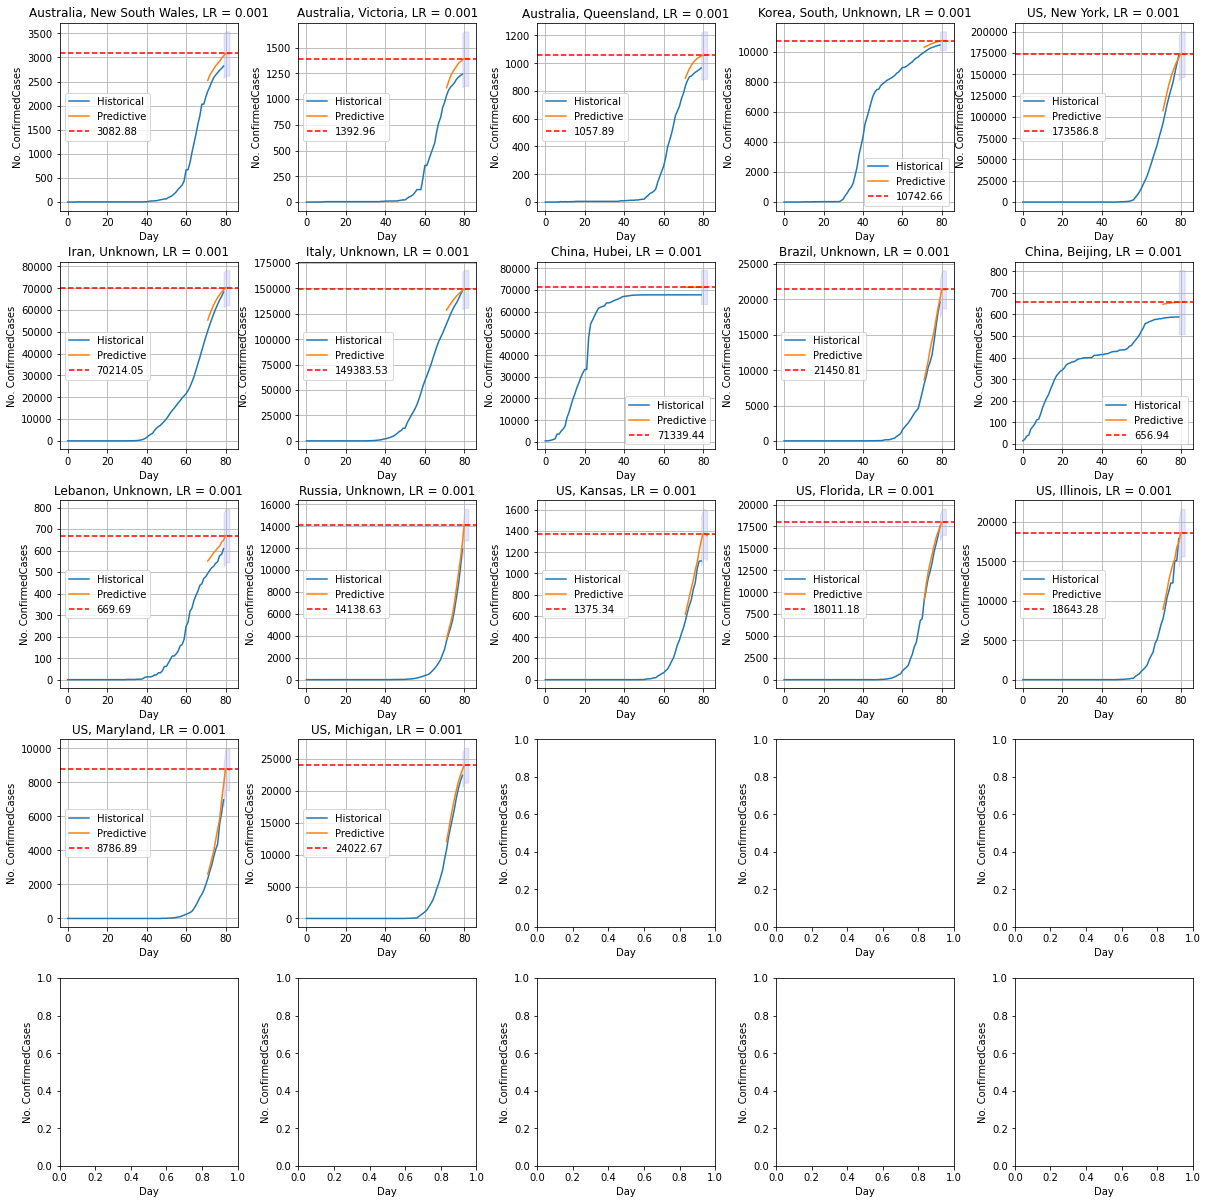

In [ ]:
hist_arr = []
pred_arr = []

for country, state in dr.country_states:
    hist_arr.append(temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day <= const.TEST_DAY_TO)].groupby(['Country_Region', 'Province_State', 'Day']).agg({'ConfirmedCases': 'first'}).reset_index())
    pred_arr.append(temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day >= const.TEST_DAY_FROM)].groupby(['Country_Region', 'Province_State', 'Day']).agg({'ConfirmedCases_inversed_predicted': 'first'}).reset_index())

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(17,17))
fig.tight_layout(pad=3.0)

for a in ax.flat:    a.set(xlabel='Day', ylabel='No. ConfirmedCases')
    
counter = 0
for row in ax:
    for col in row:
        if len(hist_arr) > counter and len(hist_arr[counter]) > 0:

            hist_df = hist_arr[counter]
            pred_df = pred_arr[counter]                       
            
            # col.title.set_text('{}, {} Learning Rate = 0.001 '.format(hist_df.Country_Region.values[0], hist_df.Province_State.values[0]))
            col.title.set_text('{}, {}, {}'.format(hist_df.Country_Region.values[0], hist_df.Province_State.values[0],"LR = 0.001"))

            col.grid()
            col.plot(hist_df.Day, hist_df.ConfirmedCases, label='Historical')
            col.plot(pred_df.Day, pred_df.ConfirmedCases_inversed_predicted, label='Predictive')               
            
            y = np.array(hist_df[(hist_df.Day >= const.TEST_DAY_FROM) & (hist_df.Day <= const.TEST_DAY_TO)].ConfirmedCases)
            y_hat = np.array(pred_df[(pred_df.Day >= const.TEST_DAY_FROM) & (pred_df.Day <= const.TEST_DAY_TO)].ConfirmedCases_inversed_predicted)
            
            sum_errs = np.sum((y-y_hat )**2)
            std = np.sqrt(1/(len(y)-2) * sum_errs)
            interval = 1.96 * std            
            fill_df = pred_df[pred_df.Day >= const.TEST_DAY_TO]
            col.fill_between(fill_df.Day, (fill_df.ConfirmedCases_inversed_predicted - interval), (fill_df.ConfirmedCases_inversed_predicted + interval), color='b', alpha=.1)
            
            col.axhline(y=pred_df.ConfirmedCases_inversed_predicted.max(), color='r', linestyle='--', label=round(pred_df.ConfirmedCases_inversed_predicted.max(), 2))
            col.legend(loc="best")
            counter += 1
from google.colab import files
plt.savefig("Mod_Model_5_FS64(Pooling_3).png")
files.download("Mod_Model_5_FS64(Pooling_3).png")      
plt.show()
# plt.savefig("Benchmark_Model.png")


# 7. Calculate the RMSE (Error)

Here we calculate errors to see how much deviated the predictions are from the actual results during the given period (Day 71 ~ 79). The lower the metric value is the more accurate the model is. RMSLE is used

In [ ]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(temp_df[(temp_df.Day >= const.TEST_DAY_FROM) & (temp_df.Day <= const.TEST_DAY_TO)].ConfirmedCases, \
                             temp_df[(temp_df.Day >= const.TEST_DAY_FROM) & (temp_df.Day <= const.TEST_DAY_TO)].ConfirmedCases_inversed_predicted)

print('RMSLE: ', math.sqrt(msle))

## model_cases = mr.create_cnn_lstm(2000, 100, 100, 64, 0.001, np.array(train_inputs), np.array(train_inputs_a), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))

RMSLE:  0.13132275904618176


# 8. Conclusion

Next time, this type of time series which can be grouped by context e.g. geo location can be forecasted by a group after clustering time series to mutiple clusters which are based on their patterns in growth curve.